In [1]:
import torch
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [2]:
torch.manual_seed(0)
torch.__version__

'2.0.1+cu117'

<IPython.core.display.Javascript object>

In [3]:
# Helper

def find_animal_name(path):
    return path.split("/")[-1].split(".")[0]

def find_names_of_all_animals(paths):

    names = []

    for path in paths:
        animal_name = find_animal_name(path)
        names.append(animal_name)

    return names

def display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)


def display_tensor_image(tensor_image):

    # CxHxW to HxWxC and from tensor to numpy array
    image_np = tensor_image.permute(1, 2, 0).numpy()
    
    # Convert numpy array to Pillow Image
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8))
    
    # Display the image using matplotlib
    plt.imshow(image_pil)
    plt.axis('off')
    plt.show()

<IPython.core.display.Javascript object>

## Prepare the data

In [4]:
data_train = "cats_dogs_light/train"
data_test = "cats_dogs_light/test"

<IPython.core.display.Javascript object>

In [5]:
# list comprehension
train_animal_paths = [os.path.join(data_train, f) for f in os.listdir(data_train)]

test_animal_paths = [os.path.join(data_test, f) for f in os.listdir(data_test)]

<IPython.core.display.Javascript object>

In [6]:
print("Length of train_animal_paths: ", len(train_animal_paths))
print("Length of test_animal_paths: ", len(test_animal_paths))

Length of train_animal_paths:  1000
Length of test_animal_paths:  400


<IPython.core.display.Javascript object>

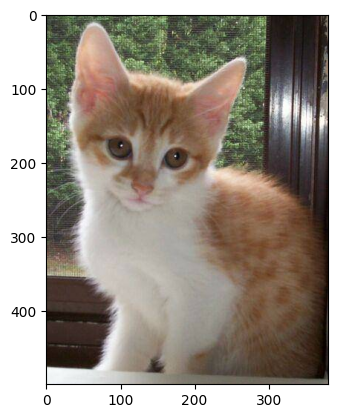

<IPython.core.display.Javascript object>

In [7]:
display_image(train_animal_paths[0])

In [8]:
train_animal_names = [find_animal_name(path) for path in train_animal_paths]

test_animal_names = [find_animal_name(path) for path in test_animal_paths]

<IPython.core.display.Javascript object>

In [9]:
# Write now we have the data as well as the ground truth for the data

<IPython.core.display.Javascript object>

## Create a PyToch Dataloader

In [10]:
from torch.utils.data import Dataset, DataLoader

<IPython.core.display.Javascript object>

In [11]:
import cv2
import numpy as np

class ImageHistogram:

    def __init__(self, image_path):
        # Load the image in its original color (OpenCV loads images in BGR order by default)
        self.image = cv2.imread(image_path)

    def compute_histogram(self, bins=256):
        # Calculate the histogram for each channel
        hist_r, _ = np.histogram(self.image[:,:,2].ravel(), bins, [0,256])  # Red channel
        hist_g, _ = np.histogram(self.image[:,:,1].ravel(), bins, [0,256])  # Green channel
        hist_b, _ = np.histogram(self.image[:,:,0].ravel(), bins, [0,256])  # Blue channel

        # Combine histograms
        combined_histogram = np.concatenate((hist_r, hist_g, hist_b))
        
        return combined_histogram

<IPython.core.display.Javascript object>

In [12]:
class CatDogDataset(Dataset):

    # like a constructor in c++
    def __init__(self, path_list, name_list):
            
            self.path_list = path_list
            self.name_list = name_list

            label_mapping = {"cat": 0, "dog": 1}

            self.label_list = [label_mapping[name] for name in name_list]

    
    def __len__(self):
        return len(self.path_list)
    
    def __getitem__(self, idx):

        image_path = self.path_list[idx]
        label = self.label_list[idx]
        
        # Load the image
        image = Image.open(image_path).convert("RGB")
        image = image.resize((256, 256))
        
        # convert to numpy array
        image = np.array(image)

        # normalize the image from 0-255 to 0-1
        image = image / 255.0

        # pillow: H x W x C
        # pytorch: C x H x W
        
        # reshape image for pytorch
        image = torch.tensor(image).permute(2, 0, 1).float()
        label = torch.tensor(label).long()

        # Histogram
        histogram = ImageHistogram(image_path)
        histogram = histogram.compute_histogram()
        histogram = torch.tensor(histogram).float()

        return image, histogram, label

        # afterwe put into dataloader
        # [image1, image2,.... image32], [label1, label2, ... label32]

<IPython.core.display.Javascript object>

In [13]:
train_dataset = CatDogDataset(train_animal_paths, train_animal_names)

print("Length of train_dataset: ", len(train_dataset))

Length of train_dataset:  1000


<IPython.core.display.Javascript object>

In [14]:
test_dataset = CatDogDataset(test_animal_paths, test_animal_names)
print("Length of test_dataset: ", len(test_dataset))

Length of test_dataset:  400


<IPython.core.display.Javascript object>

In [15]:
animal_photo, histogram, animal_name = train_dataset[0]
animal_name

tensor(0)

<IPython.core.display.Javascript object>

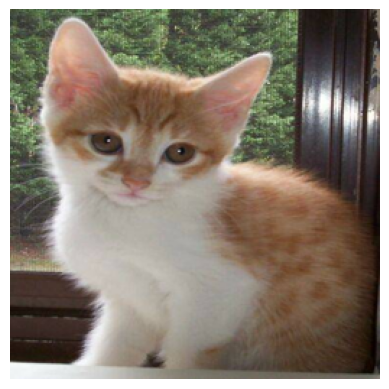

<IPython.core.display.Javascript object>

In [16]:
display_tensor_image(animal_photo)

### DataLoader

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True)

<IPython.core.display.Javascript object>

In [18]:
a = iter(train_dataloader)
b = next(a)

<IPython.core.display.Javascript object>

## Create a PyTorch Model

In [19]:
import torch.nn as nn

class CNN(nn.Module):

    def __init__(self, num_of_input_channels, num_of_classes, dropout_prob=0.2):
        super().__init__()

        # Conv layer 1
        self.conv1 = nn.Conv2d(num_of_input_channels, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv layer 3
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten
        self.flatten = nn.Flatten()

        # Dense layers
        self.fc1 = nn.Linear(64*28*28, 128)
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)

        # Output layer
        self.out = nn.Linear(128, num_of_classes)
    
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.relu1(x1)
        x3 = self.pool1(x2)
        
        x4 = self.conv2(x3)
        x5 = self.relu2(x4)
        x6 = self.pool2(x5)
        
        x7 = self.conv3(x6)
        x8 = self.relu3(x7)
        x9 = self.pool3(x8)
        
        x10 = self.flatten(x9)
        
        x11 = self.fc1(x10)
        x12 = self.relu_fc1(x11)
        x13 = self.dropout(x12)
        
        x14 = self.out(x13)
        
        return x14


<IPython.core.display.Javascript object>

In [20]:
import torch.nn as nn

class CNN(nn.Module):

    def __init__(self, num_of_input_channels, num_of_classes, dropout_prob=0.2):
        super().__init__()

        # Using nn.Sequential for Convolutional layers
        self.conv = nn.Sequential(
            # Conv layer 1
            nn.Conv2d(num_of_input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv layer 3
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv layer 4
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv layer 5
            nn.Conv2d(32, 14, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Using nn.Sequential for Dense layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(26*8*8, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(128, num_of_classes)
        )
    
    def forward(self, x, y):
        # output of conv for image
        x_r = self.conv(x)

        # xr: -> embedding from image using conv

        y1 = y.view(y.shape[0], -1, 8, 8)
        # y1: -> histogram embedding 

        # concatenate the output of conv for image and histogram
        x_r_y1 = torch.cat((x_r, y1), dim=1)

        # output of conv for histogram
        x = self.classifier(x_r_y1)
        return x

<IPython.core.display.Javascript object>

14, 14, 14 = 14 * 14 * 14 = 2744

histogram: 256+256+256 = 768: 12 *8 * 8


(32, , , )

2744/768 = 3.5729166666666665

1. We need data
2. We create pytorch dataset
3. We create pytorch dataloader
4. We create a model
5. Choose a loss function
6. Choose an optimizer
7. Train the model

initial image: 3, 224, 224
is now embedding in a dimensional space of: 64, 28, 28

In [21]:
# Model
model = CNN(num_of_input_channels=3, num_of_classes=2)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

<IPython.core.display.Javascript object>

## Train the model

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

torch.cuda.empty_cache()

Device:  cuda:0


<IPython.core.display.Javascript object>

In [23]:
EPOCHS = 10

# Move model to device
model.to(device)

for epoch in range(EPOCHS):
    total_loss = 0.0
    # a: Training
    for image, histogram, label in train_dataloader:
        image = image.to(device)
        histogram = histogram.to(device)
        label = label.to(device)

        # 1. Forward pass
        output = model(image, histogram)

        # 2. Calculate loss
        loss = loss_fn(output, label)

        # 3. Backward pass
        loss.backward()

        # 4. Update weights
        optimizer.step()

        # 5. Zero gradients
        optimizer.zero_grad()

        total_loss += loss.item()

    # b: Evaluation
    # Set to evaluation mode
    model.eval()    # Weights and biases are frozen, not updated
    total_correct = 0
    total_images = 0
    for image, histogram, label in test_dataloader:
        image = image.to(device)
        histogram = histogram.to(device)
        label = label.to(device)

        output = model(image, histogram)

        max_value, predicted = torch.max(output, 1)

        total_correct = total_correct + (predicted == label).sum().item()
        total_images = total_images + label.size(0)

    # Set back to train mode
    model.train()

    print(f"Epoch: {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_dataloader):.4f}, Accuracy: {total_correct/total_images:.2f}")

Epoch: 1/10, Loss: 82.4032, Accuracy: 0.48
Epoch: 2/10, Loss: 1.4267, Accuracy: 0.50
Epoch: 3/10, Loss: 4.2227, Accuracy: 0.51
Epoch: 4/10, Loss: 1.8230, Accuracy: 0.51
Epoch: 5/10, Loss: 1.5905, Accuracy: 0.51
Epoch: 6/10, Loss: 1.1210, Accuracy: 0.50
Epoch: 7/10, Loss: 0.6864, Accuracy: 0.49
Epoch: 8/10, Loss: 1.2085, Accuracy: 0.51
Epoch: 9/10, Loss: 1.0518, Accuracy: 0.50
Epoch: 10/10, Loss: 4.1413, Accuracy: 0.51


<IPython.core.display.Javascript object>